In [11]:
''''
Edunet Internship DataScience and Machine Learning
Group Members:
Kaustubh Bhavsar
Prajjwal Sonaje
Aditya Joshi

Domain: Data Science and Machine Learning
Project Title: Forecasting of Smart City Traffic Patterns
'''

"'\nEdunet Internship DataScience and Machine Learning\nGroup Members:\nKaustubh Bhavsar \nPrajjwal Sonaje\nAditya Joshi\n\nDomain: Data Science and Machine Learning\nProject Title: Forecasting of Smart City Traffic Patterns\n"

In [12]:
# 1. Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


In [13]:
# 2.Loading the Dataset

from google.colab import drive
import pandas as pd

# Mounting Google Drive
drive.mount('/content/drive', force_remount=True)

# Loading the training dataset
df = pd.read_csv('/content/drive/My Drive/AI/train.csv')

# Loading the testing dataset if needed
df_other = pd.read_csv('/content/drive/My Drive/AI/test.csv')

df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_other['DateTime'] = pd.to_datetime(df_other['DateTime'], format='%Y-%m-%d %H:%M:%S')

# Basic info
print(df.info())
print(df.head())


Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB
None
             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041


In [14]:
# 3. Data Preprocessing

# Missing values if any
df = df.dropna()

# Extracting useful features from datetime
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Weekend'] = (df['DayOfWeek'] >= 5).astype(int)


# Spliting the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)


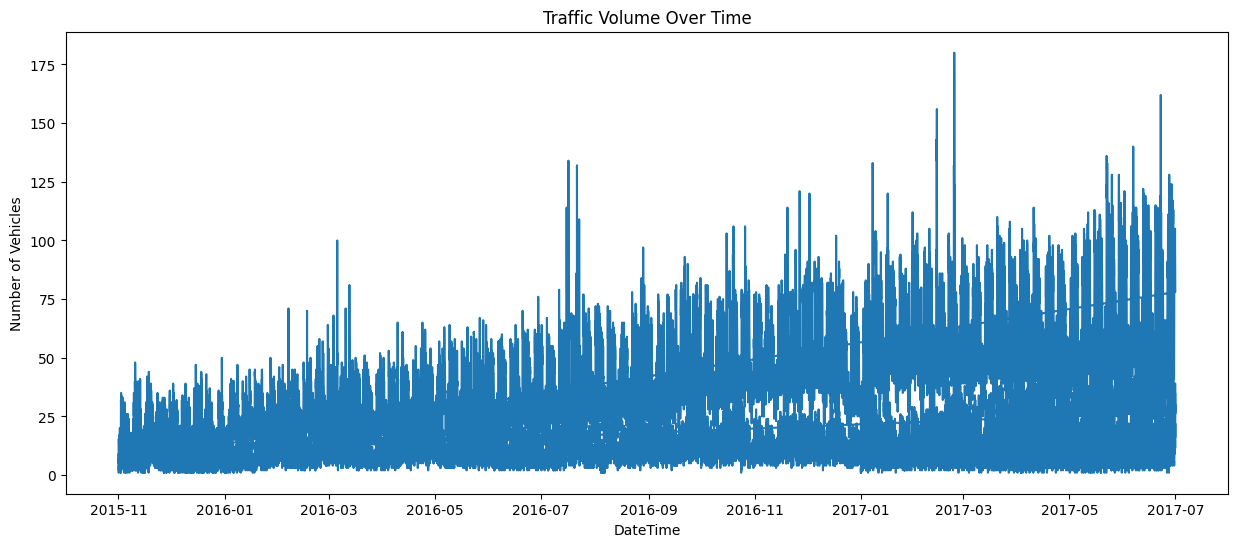

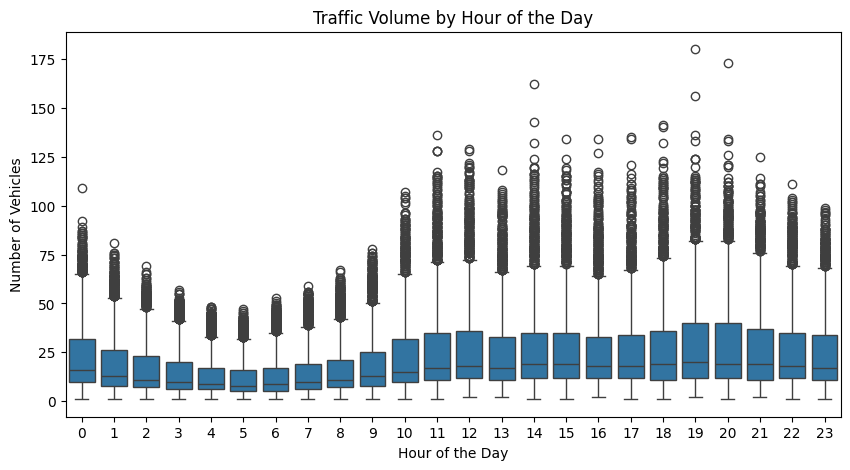

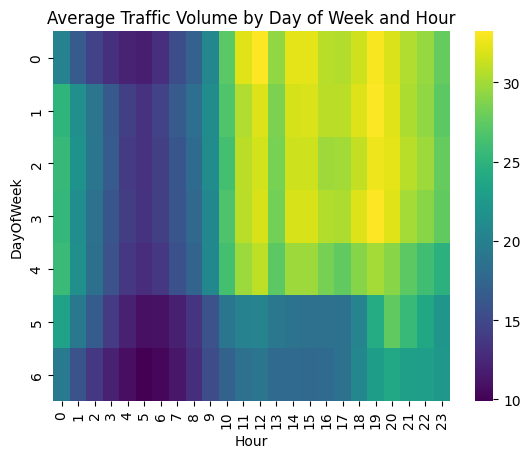

In [15]:
# 4. Exploratory Data Analysis (EDA)
# Plotting traffic volume over time

plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['Vehicles'])
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.title('Traffic Volume Over Time')
plt.show()

# Plotting traffic volume by hour of the day
plt.figure(figsize=(10, 5))
sns.boxplot(x='Hour', y='Vehicles', data=df)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Vehicles')
plt.title('Traffic Volume by Hour of the Day')
plt.show()

# Heatmap of traffic volume by day and hour
pivot_table = df.pivot_table(values='Vehicles', index='DayOfWeek', columns='Hour', aggfunc=np.mean)
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Average Traffic Volume by Day of Week and Hour')
plt.show()


In [16]:
# 5. Model Implementation

# Training ARIMA model
arima_model = ARIMA(train_df['Vehicles'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

# Predicting using ARIMA model
arima_predictions = arima_model_fit.forecast(steps=len(test_df))
arima_mae = mean_absolute_error(test_df['Vehicles'], arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(test_df['Vehicles'], arima_predictions))
arima_r2 = r2_score(test_df['Vehicles'], arima_predictions)

print(f'ARIMA MAE: {arima_mae}')
print(f'ARIMA RMSE: {arima_rmse}')
print(f'ARIMA R2: {arima_r2}')


                               SARIMAX Results                                
Dep. Variable:               Vehicles   No. Observations:                38496
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -116089.948
Date:                Sun, 30 Jun 2024   AIC                         232191.896
Time:                        11:33:19   BIC                         232243.245
Sample:                             0   HQIC                        232208.179
                              - 38496                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0762      0.002     42.488      0.000       0.073       0.080
ar.L2          0.0762      0.002     33.515      0.000       0.072       0.081
ar.L3          0.0598      0.003     18.804      0.0

In [ ]:
# Preparing data for LSTM
train_data = train_df['Vehicles'].values.reshape(-1, 1)
test_data = test_df['Vehicles'].values.reshape(-1, 1)

# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Creating sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 24  # Using past 24 hours to predict the next hour
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Building LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predicting using LSTM model
lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_mae = mean_absolute_error(test_data[seq_length:], lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(test_data[seq_length:], lstm_predictions))
lstm_r2 = r2_score(test_data[seq_length:], lstm_predictions)

print(f'LSTM MAE: {lstm_mae}')
print(f'LSTM RMSE: {lstm_rmse}')
print(f'LSTM R2: {lstm_r2}')


Epoch 1/20
1203/1203 [==============================] - 35s 27ms/step - loss: 0.0017
Epoch 2/20
 427/1203 [=========>....................] - ETA: 12s - loss: 8.7003e-04

In [ ]:
# Preparing features for Random Forest and Gradient Boosting
features = ['Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'Weekend']
X_train = train_df[features]
y_train = train_df['Vehicles']
X_test = test_df[features]
y_test = test_df['Vehicles']

# Training Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print(f'Random Forest MAE: {rf_mae}')
print(f'Random Forest RMSE: {rf_rmse}')
print(f'Random Forest R2: {rf_r2}')

# Training Gradient Boosting model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
gb_r2 = r2_score(y_test, gb_predictions)

print(f'Gradient Boosting MAE: {gb_mae}')
print(f'Gradient Boosting RMSE: {gb_rmse}')
print(f'Gradient Boosting R2: {gb_r2}')


In [ ]:
# 6. Model Evaluation and Comparison
# Comparing model performance
results = {
    'Model': ['ARIMA', 'LSTM', 'Random Forest', 'Gradient Boosting'],
    'MAE': [arima_mae, lstm_mae, rf_mae, gb_mae],
    'RMSE': [arima_rmse, lstm_rmse, rf_rmse, gb_rmse],
    'R2': [arima_r2, lstm_r2, rf_r2, gb_r2]
}
results_df = pd.DataFrame(results)
print(results_df)

# Plot predictions
plt.figure(figsize=(15, 6))
plt.plot(test_df['DateTime'], test_df['Vehicles'], label='Actual', color='black')
plt.plot(test_df['DateTime'], arima_predictions, label='ARIMA Predictions')
plt.plot(test_df['DateTime'][seq_length:], lstm_predictions, label='LSTM Predictions')
plt.plot(test_df['DateTime'], rf_predictions, label='Random Forest Predictions')
plt.plot(test_df['DateTime'], gb_predictions, label='Gradient Boosting Predictions')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.title('Traffic Predictions vs Actual')
plt.legend()
plt.show()

# Bar chart of performance metrics
metrics = ['MAE', 'RMSE', 'R2']
x = np.arange(len(metrics))  # label locations
width = 0.2  # bar width

fig, ax = plt.subplots()
bar1 = ax.bar(x - width*1.5, results_df.loc[0, metrics], width, label='ARIMA')
bar2 = ax.bar(x - width/2, results_df.loc[1, metrics], width, label='LSTM')
bar3 = ax.bar(x + width/2, results_df.loc[2, metrics], width, label='Random Forest')
bar4 = ax.bar(x + width*1.5, results_df.loc[3, metrics], width, label='Gradient Boosting')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()
